Deep Q Network applied to environment. I would suggest reading through this one first as I go over some of the shortcomings of this method, and how the policy gradient approach works better. 

In [3]:
%matplotlib inline
import gym
from gym import wrappers

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time # just to have timestamps in the files


In [14]:
#initialize environment, device, and hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1')

batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 1e-3
target_update = 10
memory_size = 10000
lr = 0.001
num_episodes = 1000

In [15]:
class DQN(nn.Module):
    
    """
    Input the shape of observations, which is 4 for cartpole.
    """
    def __init__(self):
        super().__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.fc1 = nn.Linear(in_features=self.state_space, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.fc3 = nn.Linear(in_features=32,out_features=24)
        self.out = nn.Linear(in_features=24, out_features=self.action_space)
    
    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))

        t = self.out(t)
        return t
    
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)
    
    
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                # convert current state to a tensor
                state = torch.tensor(state).reshape(-1,4).float()
                return policy_net(state).argmax().to(self.device) # exploit

In [16]:
policy_net = DQN().to(device)
target_net = DQN().to(device) #this one gets updated occasionally

In [17]:
# utility functions

def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.tensor(batch.state)
    t2 = torch.tensor(batch.action)
    t3 = torch.tensor(batch.reward)
    t4 = torch.tensor(batch.next_state)
    t5 = torch.tensor(batch.done)
#should I include a done bool?
    return (t1.float(),t2.float(),t3.float(),t4.float(),t5.float())


Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward','done')
)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [18]:
class QValues():
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1).long())
    
    @staticmethod        
    def get_next(target_net, next_states,dones):  #if done, need to include to set as 0   
        done_mask = dones == 1 # if true, set to 0
        values = target_net(next_states).max(dim=1)[0].detach()
        values[done_mask] = 0.
        return values


In [19]:
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, env.action_space.n, device)
memory = ReplayMemory(memory_size)
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
total_rewards = []
RENDER = True

In [20]:
env = wrappers.Monitor(env, '../videos/DQN/', force = True)


In [21]:
for episode in range(num_episodes):
    state = env.reset() #initial state
    done = False
    timestep = 0
    while not done:
        if RENDER:
            #every 5 episodes, render progress. 
            if episode % 5 == 0:
                env.render()
        timestep += 1
        action = agent.select_action(state, policy_net).item()
        next_state, reward, done, info = env.step(action)
        
        memory.push(Experience(state, action, next_state, reward,done))
        
        state = next_state

        #once enough replays are collected so it is possible to learn. 
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states, dones = extract_tensors(experiences)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states,dones)
            target_q_values = (next_q_values * gamma) + rewards
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    total_rewards.append(timestep)
    

env.close()


KeyboardInterrupt: 

In [22]:
def running_mean(x, N):
    """
    Useful function to smooth rewards over episodes. 
    """
    cumsum = np.cumsum(np
                       .insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

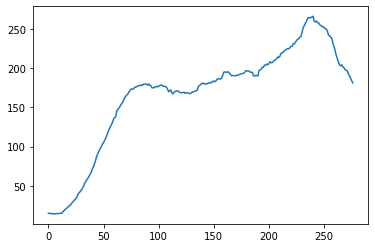

In [23]:
plt.plot(running_mean(total_rewards,50))

So something that suprised me (and you too) is that this method does far better in terms of accumulating reward and staying alive in this task as compared to the policy gradient approach. 


One first disclaimer in this is that I did basically no hyperparameter tuning for the policy gradient, whereas the DQN I spent a ton of time tuning at first and more or less wanted to gain a basic understanding and implementation of policy gradients. All this to say I think if I spent enough time, I could get the policy gradient to work a lot quicker. 


Additionally, one of the shortcomings of the DQN is that I basically had to hard code in the action space. For a network which needs to predict an infinite number of actions, this can be problematic. Policy gradients resolve this by computing probability distributions for a set of actions which is a lot easier to look into. 

And lastly, the DQN predicts deterministic values, and definitely tells you to go left or right (or whatever the action is). Policy networks will output a probability distribution which you draw from, so there is already some inherent stochasity involved and no longer requires this hard coded in exploration via epsilon greedy. 


Of course there are caveats to Policy Gradients too, but I'll leave that for another time... 



